# Non-Intrusive Load Monitoring Report 1

Analysis on the REDD dataset energy disaggregation with the end purpose of classifying energy consumption of each appliances in a house based on the whole electrical consumption reading of the house using machine learning algorithms.

For the first report, we tried to do some basic data frame manipulation and data visualization, along with applying least square method on the data

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns

#pd.set_option('display.width', 500)
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.notebook_repr_html', True)
import datetime
import time
import glob

path = 'low_freq/house_{}/'
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['figure.figsize'] = (24,16)

Get house data labels numbered with num

In [2]:
def get_labels(num):
    house_labels = (path + 'labels.dat').format(num)
    labels = {}
    with open(house_labels, mode='r') as f:
        for line in f:
            split_line = line.split(' ')
            labels[int(split_line[0])] = split_line[1].strip() + '_' + split_line[0]

    return labels

house_labels = {num: get_labels(num) for num in range(1,7)}
for num in range(1,7):
    print('House {}: '.format(num), house_labels[num], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

There are 6 house in the dataset, however only house data 1 and 2 are going to be used.

In [3]:
def get_data(house):
    house_path = path.format(house)
    
    #get the number of files which contains channel in the path directory
    num_appliances = len(glob.glob(house_path + 'channel*'))
    data_list = []
    for i in range(1, num_appliances + 1):
        file = house_path + 'channel_{}.dat'.format(i)
        data_list.append(pd.read_csv(file, sep=' ',
                                       names = ['unix_time', house_labels[house][i]],
                                       dtype = {'unix_time' : 'int64', 
                                                house_labels[house][i] : 'float64'}))
    
    df = data_list[0]
    for data in data_list[1:]:
        df = pd.merge(df, data, how='inner', on = 'unix_time')
    
    #converts unix_timestamp into standard timestamp and set as index
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df

df = {key: get_data(key) for key in house_labels}
show_threshold = 3

for key in df:
    if key < show_threshold:
        print('House {} data has shape: '.format(key), df[key].shape)
        display(df[key].head(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-04-18 13:22:13,222.20,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:16,223.17,119.19,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:20,223.60,118.92,0.0,0.0,6.0,0.0,34.0,22.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-04-18 05:31:40,15.71,22.61,1.0,8.0,1.0,4.0,4.0,4.0,6.0,1.0,0.0
2011-04-18 05:31:44,15.71,22.61,0.0,8.0,1.0,5.0,5.0,4.0,6.0,0.0,0.0
2011-04-18 05:31:47,15.72,22.61,1.0,8.0,1.0,4.0,4.0,4.0,6.0,1.0,0.0


The power readings for each appliances are sampled every 3 seconds except for the main meter which are sampled every 1s. To merge the data, only the data every 3 seconds are taken into the mains data.

Next lets check how many days of power data are recorded at each house.

In [4]:
dates = {}
text = 'House {0} has {1} days of power data from {2} to {3}.'
for key in df:
    dates[key] = sorted(list(set([str(time)[:10] for time in df[key].index.values])))
    print(text.format(key,len(dates[key]),dates[key][0],dates[key][-1]))

House 1 has 23 days of power data from 2011-04-18 to 2011-05-24.
House 2 has 16 days of power data from 2011-04-18 to 2011-05-22.
House 3 has 26 days of power data from 2011-04-16 to 2011-05-31.
House 4 has 26 days of power data from 2011-04-17 to 2011-06-04.
House 5 has 9 days of power data from 2011-04-18 to 2011-06-01.
House 6 has 17 days of power data from 2011-05-21 to 2011-06-14.


Showing power consumption of each house's appliance over the course of a day

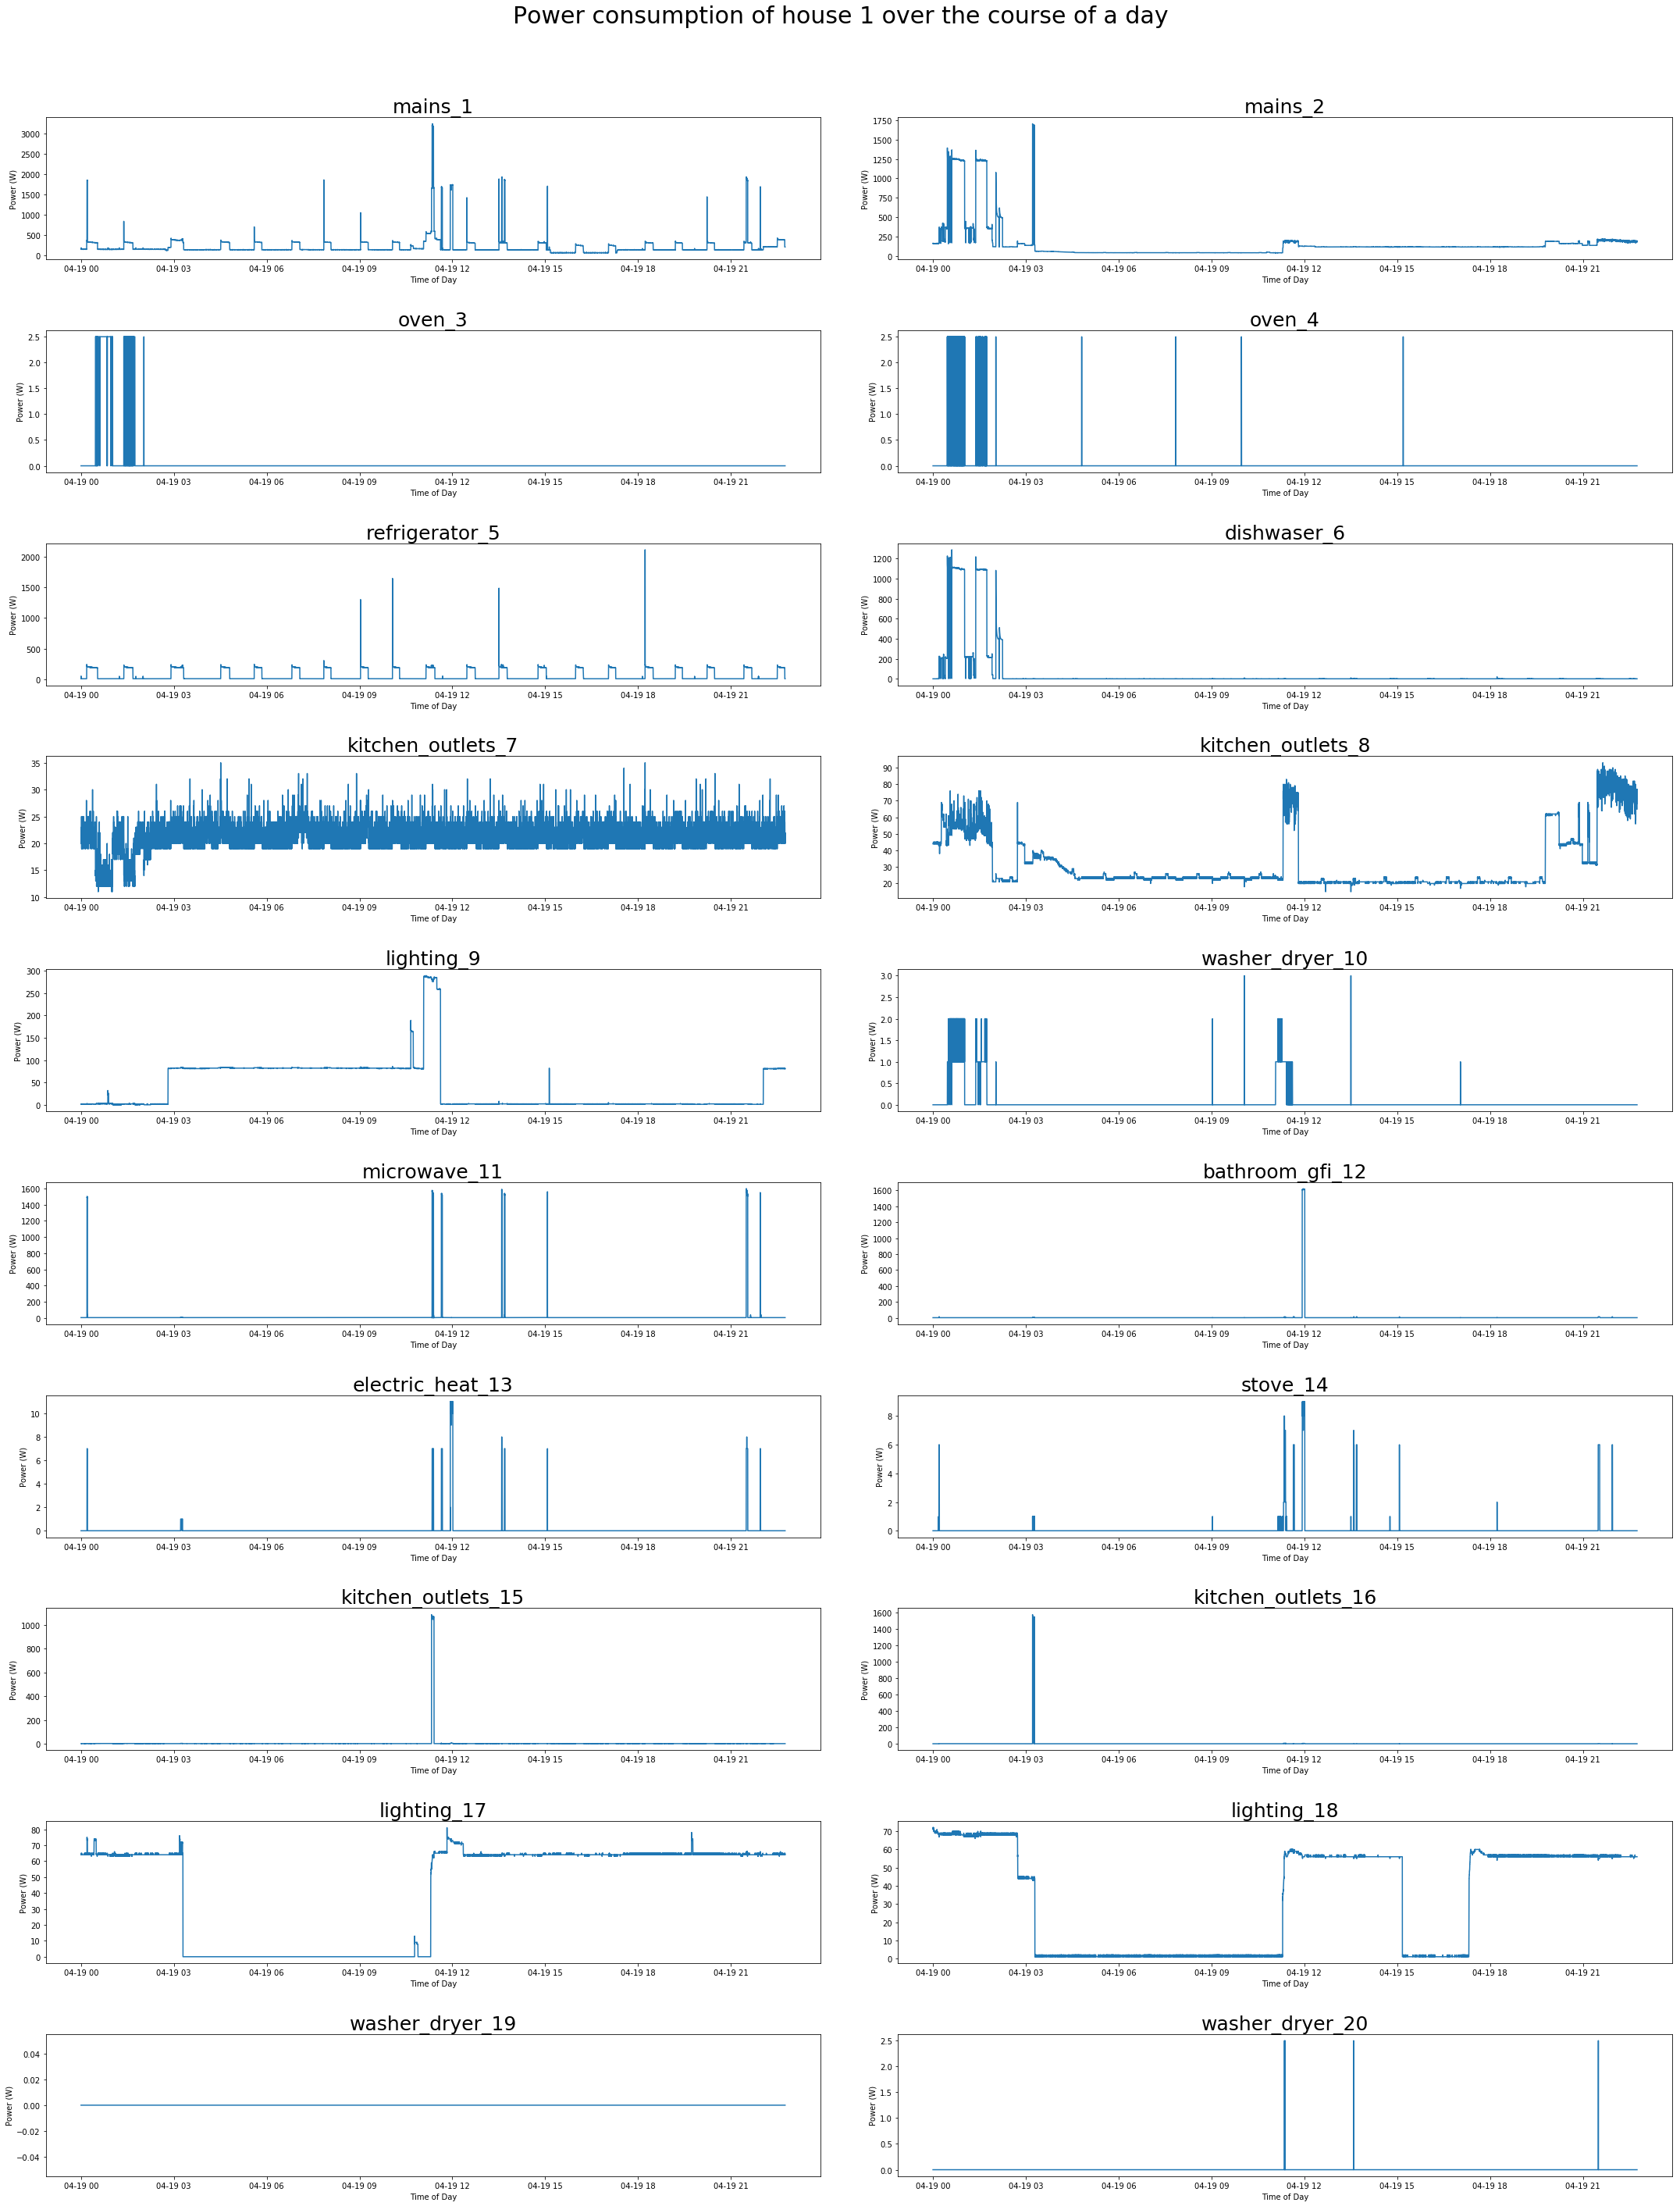

In [240]:
def plot_data(df, house_num, title):
    apps = df.columns.values
    num_apps = len(apps)
    
    fig, axes = plt.subplots((num_apps+1)//2, 2, figsize=(30,40))
    i = 0
    for app in apps:
        if i <= num_apps:
            axes.flat[i].plot(df.loc[dates[house_num][1], app])
            axes.flat[i].set_title(app, fontsize='25')
            #axes[i].set_xticks(np.arange(1, 86400, 10800))
            axes.flat[i].set_xlabel('Time of Day')
            axes.flat[i].set_ylabel('Power (W)')
            i += 1
        
    plt.suptitle(title, fontsize='30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, hspace=0.5, wspace=0.1)
    
plot_data(df[1], 1, 'Power consumption of house 1 over the course of a day')

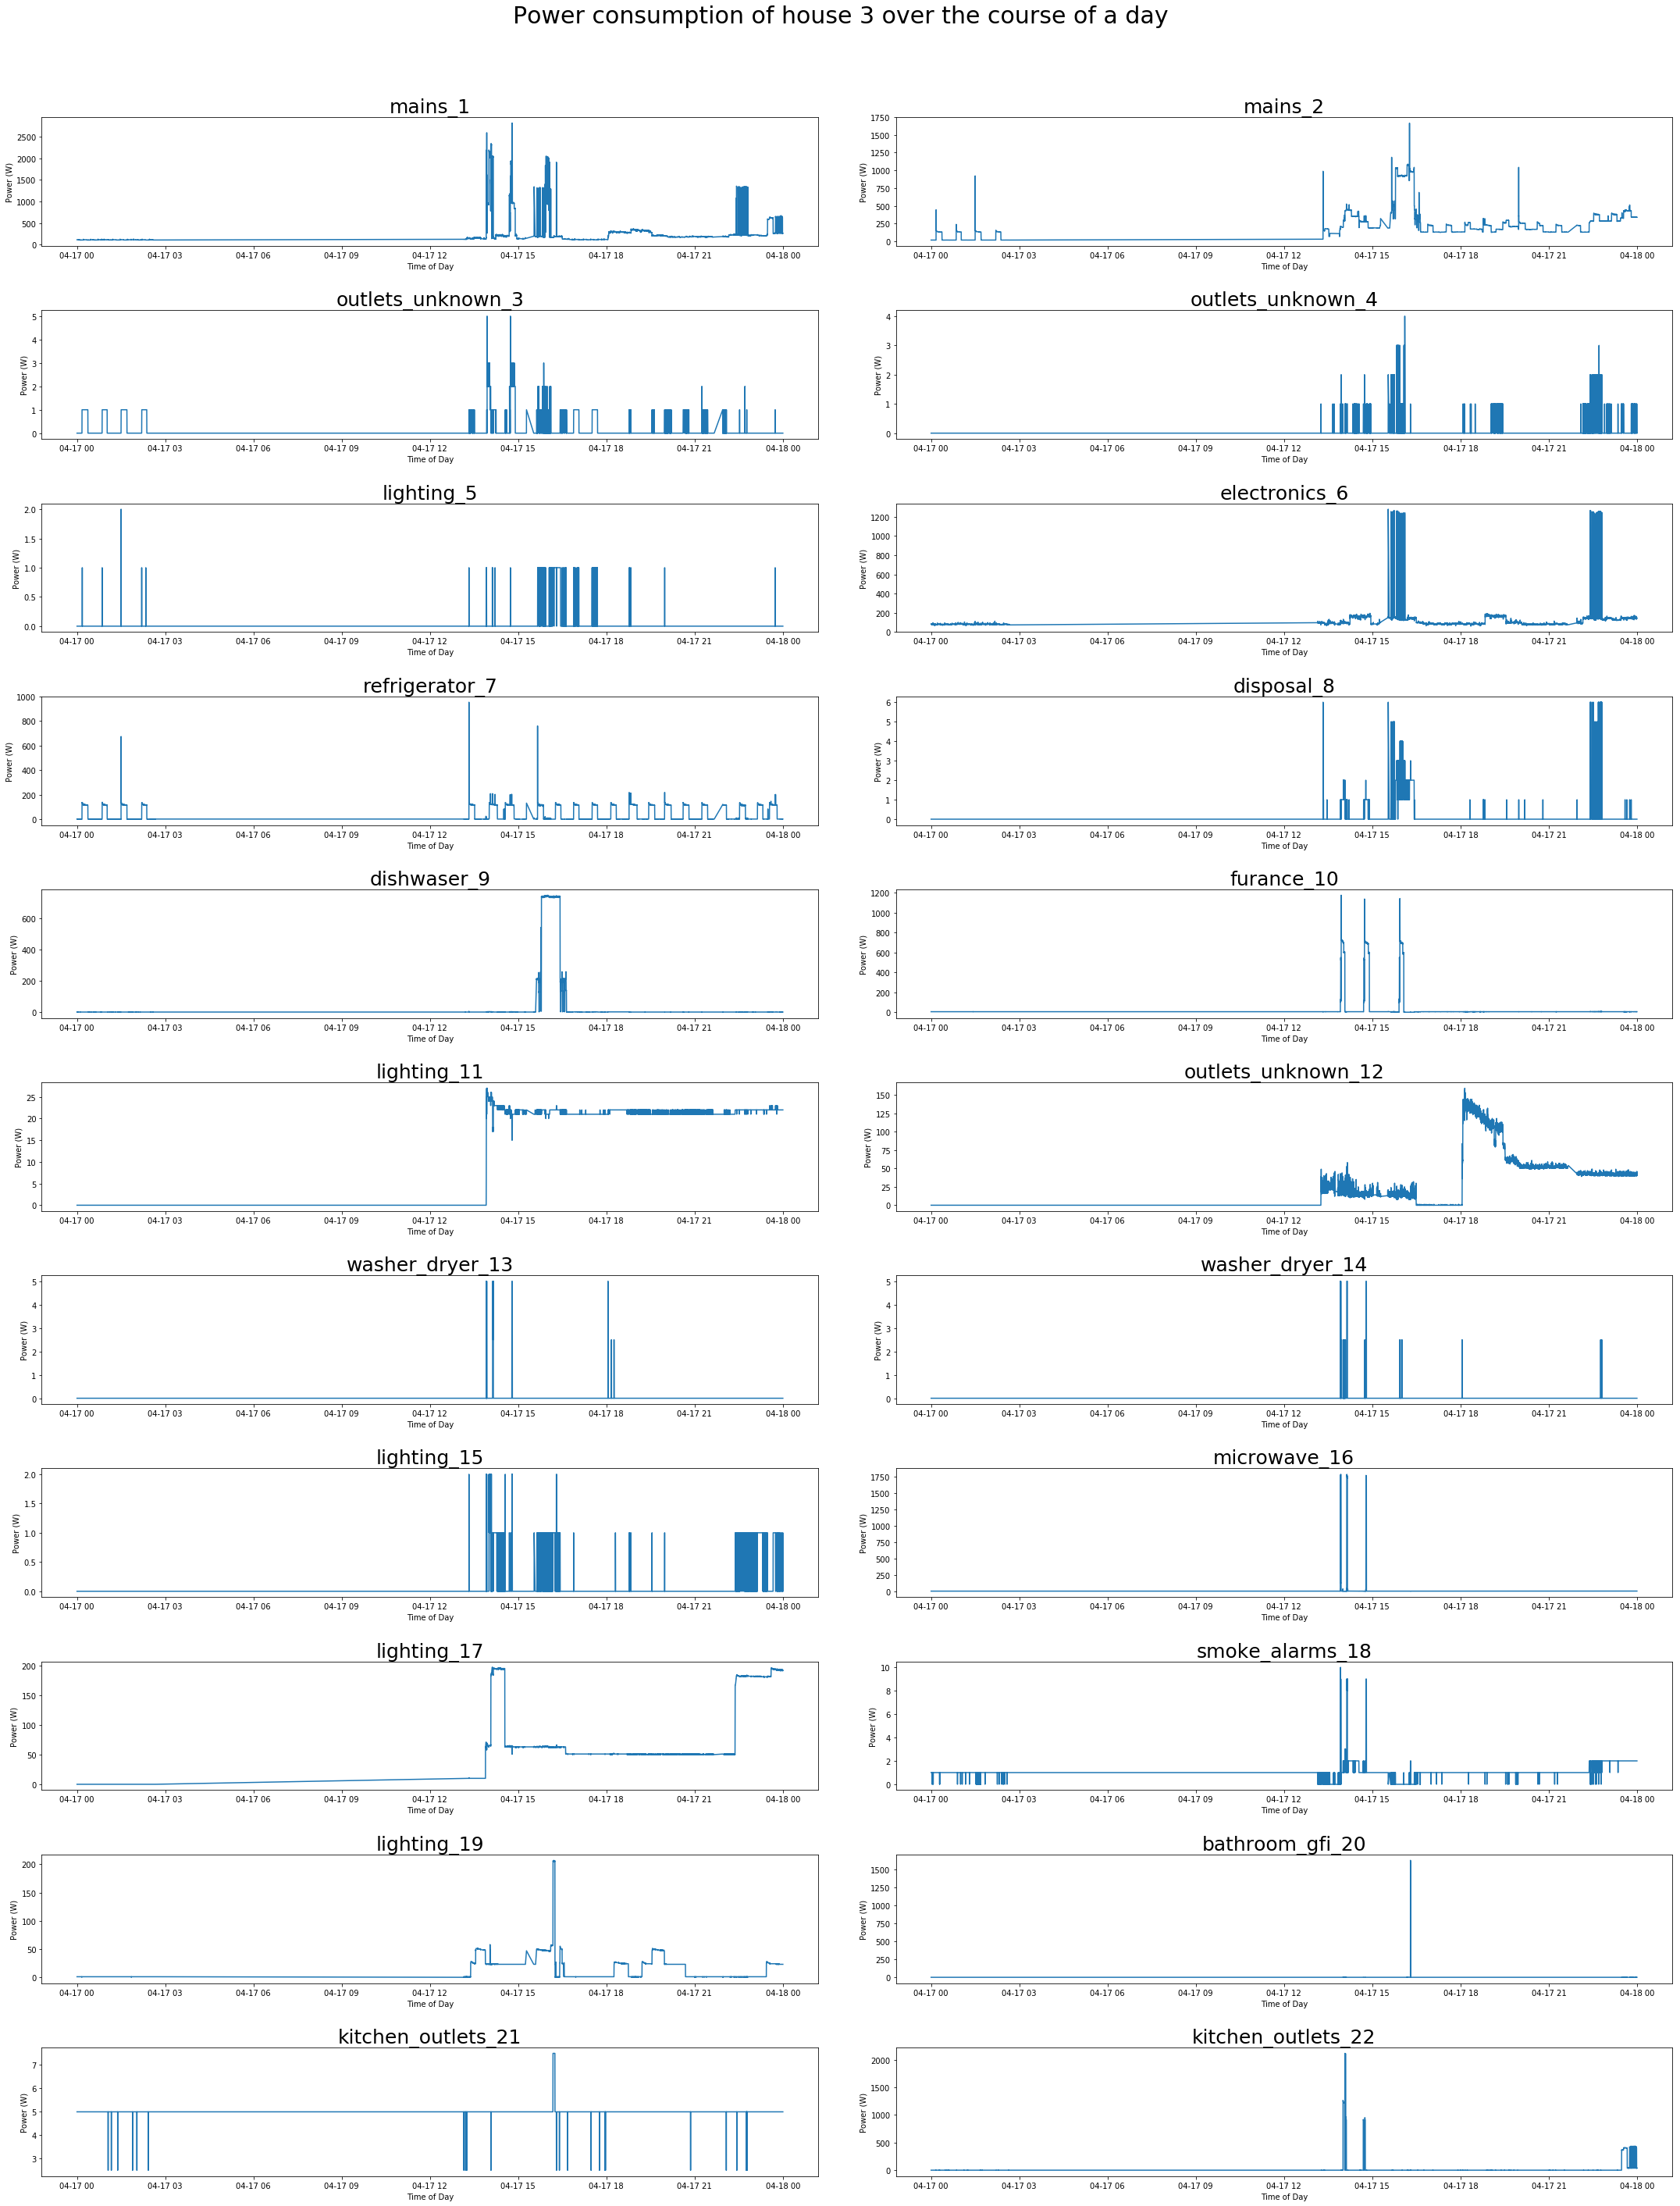

In [255]:
plot_data(df[3], 3, 'Power consumption of house 3 over the course of a day')

Plot the histogram of each house's appliance total power consumptions.

mains corresponds to the house main meter readings.

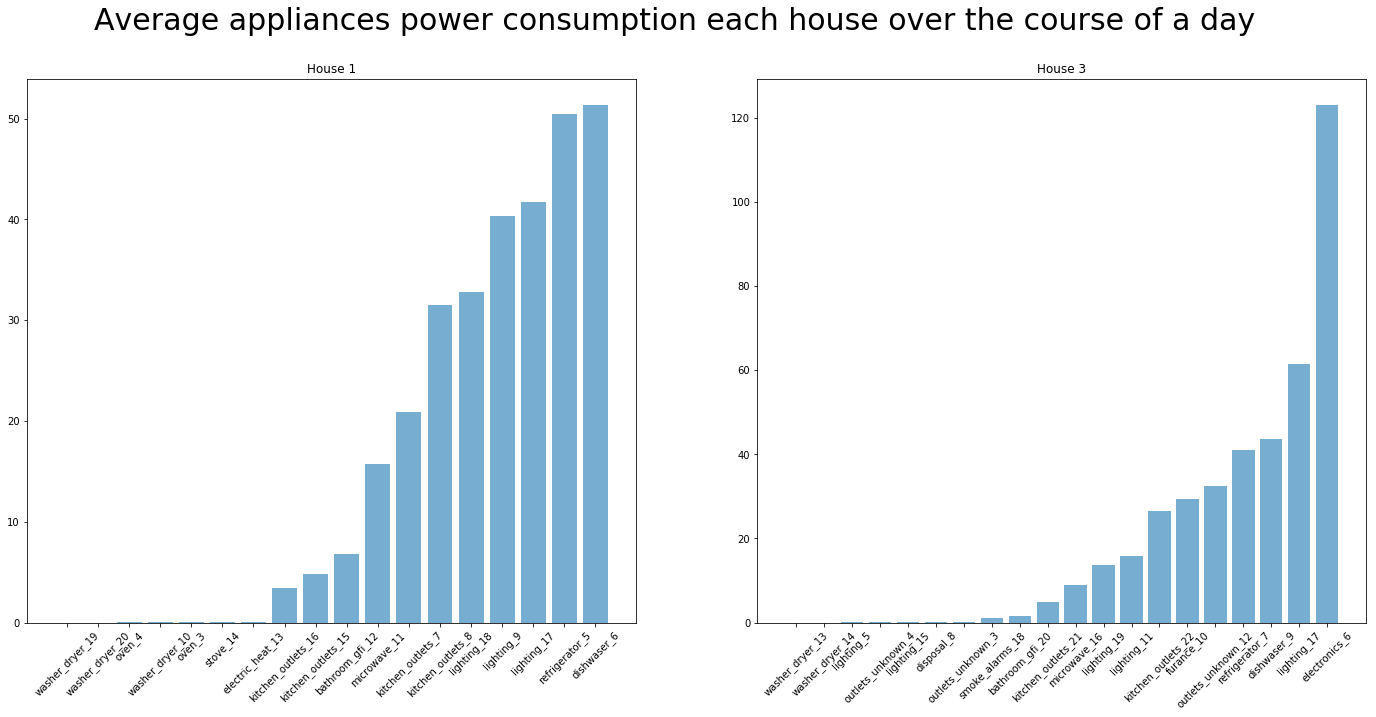

In [242]:
def plot_hist_data(df, house_nums):
    fig, axes = plt.subplots(len(house_nums)//2,2,figsize=(24, 10))
    plt.suptitle('Average appliances power consumption each house over the course of a day', fontsize=30)
    
    i = 0
    for num in house_nums:
        if i < len(house_nums):
            total = df[num].loc[dates[num][1], df[num].columns.values[2:]].mean().sort_values(ascending=True)
            appliances = total.index
            x = np.arange(len(appliances))
            axes.flat[i].bar(x, total.values, alpha=0.6)
            plt.sca(axes.flat[i])
            plt.xticks(x, appliances, rotation = 45)
            plt.title('House {}'.format(num))
            i += 1
            
    plt.subplots_adjust(hspace=0.5)

plot_hist_data(df, [1,3])

#### Applying least square method on house 1

method can be used by storing the power consumption of each appliances into a vector of variables such that

$$ X = [P_1, \: P_2, \: ... \: P_m]^T $$

where $P_m$ is the average power consumption of the $m^{th}$ appliance.

We will then use this for fitting our regression model to find a vector of regression coefficient $\hat{\beta} = [\hat{\beta_1} ... \hat{\beta_m}]^T$ by solving the least square function

$$ Y = X\hat{\beta} + \epsilon $$

So the cost function is:

$$ J = \sum (Y_{total} - X\hat{\beta} - \epsilon)^2 $$

where $Y_{total}$ is the average aggregate power consumption recorded by the main smart meter.

In [243]:
#get the average daily data
day_df = {}
for key in df:
    day_aggregate = {}
    for date in dates[key]:
        day_aggregate[date] = df[key].loc[date].mean()
        
    day_df[key] = pd.DataFrame(day_aggregate).transpose()
    day_df[key].index = day_df[key].index.astype("datetime64[s]")

display(day_df[1].head())
display(day_df[3].head())

,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-04-18,260.808521,163.089411,30.366835,45.677215,65.128709,0.113114,22.249013,38.445671,26.304608,0.003848,50.283443,9.937620,0.290835,0.240608,1.104506,15.054481,28.661772,23.242835,0.000253,0.004810
2011-04-19,197.868042,160.928340,0.080424,0.028665,50.478739,51.356745,20.908226,31.530081,40.320954,0.070142,15.766549,6.820072,0.092424,0.084672,4.800854,3.475861,41.768777,32.771655,0.000000,0.000464
2011-04-20,199.981305,73.681877,0.002721,0.001701,53.357927,0.056095,21.291538,28.922320,46.627199,0.006621,28.253991,8.137221,0.155360,0.148513,5.146427,0.065890,17.867812,15.913659,0.000000,0.000567
2011-04-21,166.193312,62.589383,0.000849,0.000708,47.858623,0.048805,21.299570,28.396105,40.410429,0.001472,16.884554,6.170422,0.093591,0.086287,5.191994,0.048919,9.588891,8.002265,0.000000,0.000425
2011-04-22,167.262127,58.122085,0.000336,0.000112,51.771869,0.059585,21.385352,26.663175,47.467947,0.007207,9.195855,8.932895,0.074089,0.073373,4.797207,0.046826,8.924568,3.334094,0.000000,0.000448


,mains_1,mains_2,outlets_unknown_3,outlets_unknown_4,lighting_5,electronics_6,refrigerator_7,disposal_8,dishwaser_9,furance_10,...,washer_dryer_13,washer_dryer_14,lighting_15,microwave_16,lighting_17,smoke_alarms_18,lighting_19,bathroom_gfi_20,kitchen_outlets_21,kitchen_outlets_22
2011-04-16,230.230522,126.282429,0.229745,0.039678,0.038753,112.852386,46.264983,0.069367,1.058084,35.216056,...,0.089946,0.078154,0.127451,8.436829,32.422956,0.988809,14.892527,6.986866,2.062246,5.098455
2011-04-17,257.343820,225.294783,0.233342,0.088308,0.052239,123.068495,41.147659,0.184066,43.712979,29.478198,...,0.018627,0.024130,0.141055,8.939633,61.511134,1.088816,13.621793,1.554483,5.006562,26.646770
2011-04-18,214.822890,236.300050,0.425795,0.105831,12.576629,106.642304,49.237989,0.046666,0.816328,4.952383,...,0.012356,0.020553,0.350283,7.469752,61.938222,1.196692,21.153163,31.051300,5.057858,17.744381
2011-04-19,236.246670,359.967646,1.089268,0.159713,0.305647,159.284689,65.403260,0.100524,0.623520,48.778382,...,0.079080,0.000000,0.204541,2.340578,74.070056,0.942558,16.630312,0.000000,4.982049,2.487871
2011-04-20,410.376138,302.515492,5.449744,0.112942,0.057452,98.091709,38.779886,0.229095,0.926609,36.148864,...,137.093940,182.488403,0.354288,6.167896,31.213513,0.813370,23.651659,19.662038,2.648240,14.002617


In [244]:
def func(x, a, eps):
    return x*a + eps

xdata = day_df[1].loc[dates[1][1]:, day_df[1].columns.values[2]:]
xdata = xdata.sum(axis=1).values
#xdata = np.transpose(xdata)
ydata = day_df[1].loc[dates[1][1]:, :day_df[1].columns.values[1]]
ydata = ydata.sum(axis=1).values
params, pcov = sp.optimize.curve_fit(func, xdata, ydata, p0=[1,1])
params

array([   1.95188411, -173.45958279])

Text(0.5, 0.98, 'Least Square Fit on House 1 power consumption data')

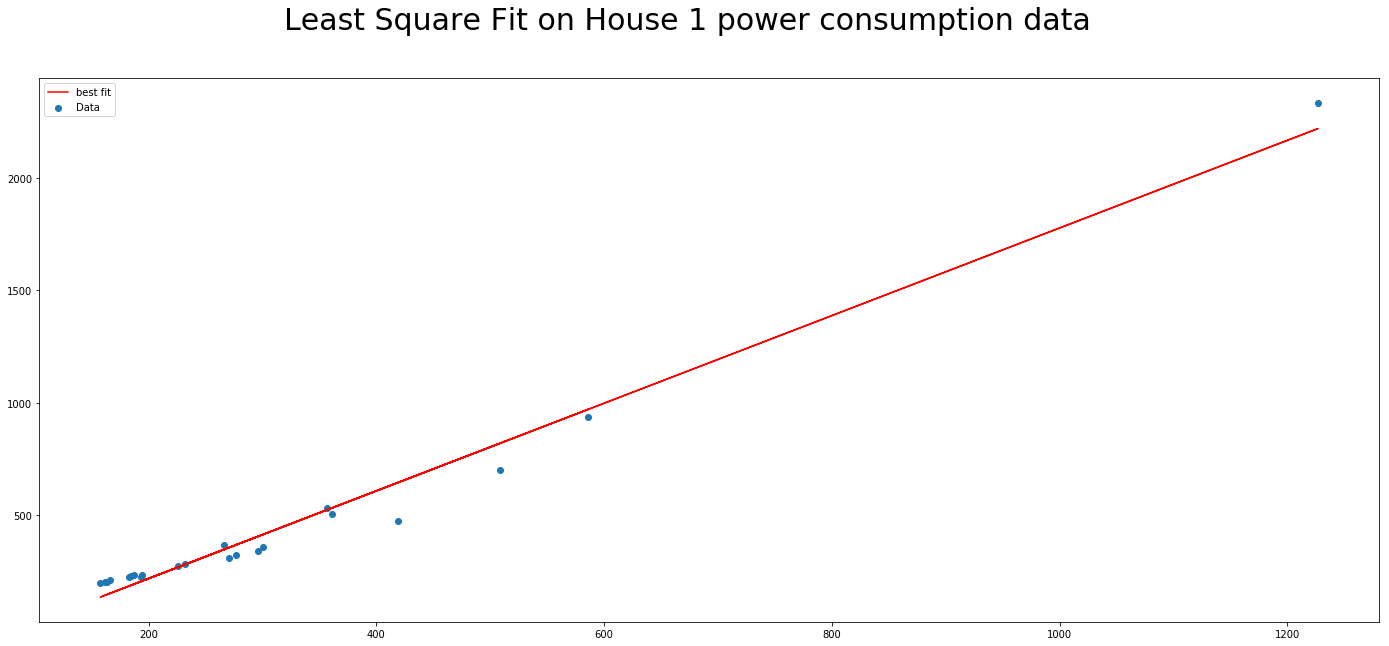

In [245]:
plt.figure(figsize=(24,10))
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, func(xdata, params[0], params[1]), 
         'r-', label='best fit')
plt.legend(loc='upper left')
plt.suptitle('Least Square Fit on House 1 power consumption data', fontsize=30)

Next, the residual sum of squares and $R^2$ value can be found from the parameters obtained by the least square fit

In [246]:
#residual sum of squares
residuals = ydata - func(xdata, params[0], params[1])
ss_res = np.sum(residuals**2)
print('Residuals Sum of Squares: {}'.format(ss_res))

#total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
print('Total Sum of Squares: {}'.format(ss_tot))

Residuals Sum of Squares: 90094.8434207438
Total Sum of Squares: 4478263.057562533


In [247]:
#R_square
r_squared = 1 - (ss_res / ss_tot)
print('R squared value: {}'.format(r_squared))

R squared value: 0.9798817438228424


## Data pre-processing

Before we proceed, we need to denoise and smoothen the power signal. This is mainly to minimize false positives on the event detection algorithm in the following sections.

We will apply median filter which is a common preprocessing, this method is often used as it can remove impulsive noises while preserving the sharpness of the edges. Each sample in the power signal $p_i$ is replaced by the median of it's $m$ neighbors:

$$ p_i = median(p_{i-m/2} + p_{i-m/2+1} + ... + p_{i+m/2-1} + p_{i+m/2}) $$

In [248]:
from scipy.signal import medfilt

def median_filter(df, house_num):
    median_filtered_df = {}
    for key in house_num:
        mf = medfilt(df[key].loc[:,'mains_1'].values)
        for apps in df[key].columns.values[1:]:
            mf = np.column_stack((mf, medfilt(df[key].loc[:,apps].values)))
        
        median_filtered_df[key] = pd.DataFrame(mf, index=df[key].index.values,
                                               columns=df[key].columns.values)
    
    return median_filtered_df

In [251]:
median_filtered_df = median_filter(df, [1,3])
display(median_filtered_df[1].head())

,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-04-18 13:22:13,222.20,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:16,223.17,118.92,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:20,223.17,119.16,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:23,222.94,118.92,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:26,222.91,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,65.0,46.0,0.0,0.0


Showing load signal after median filtering

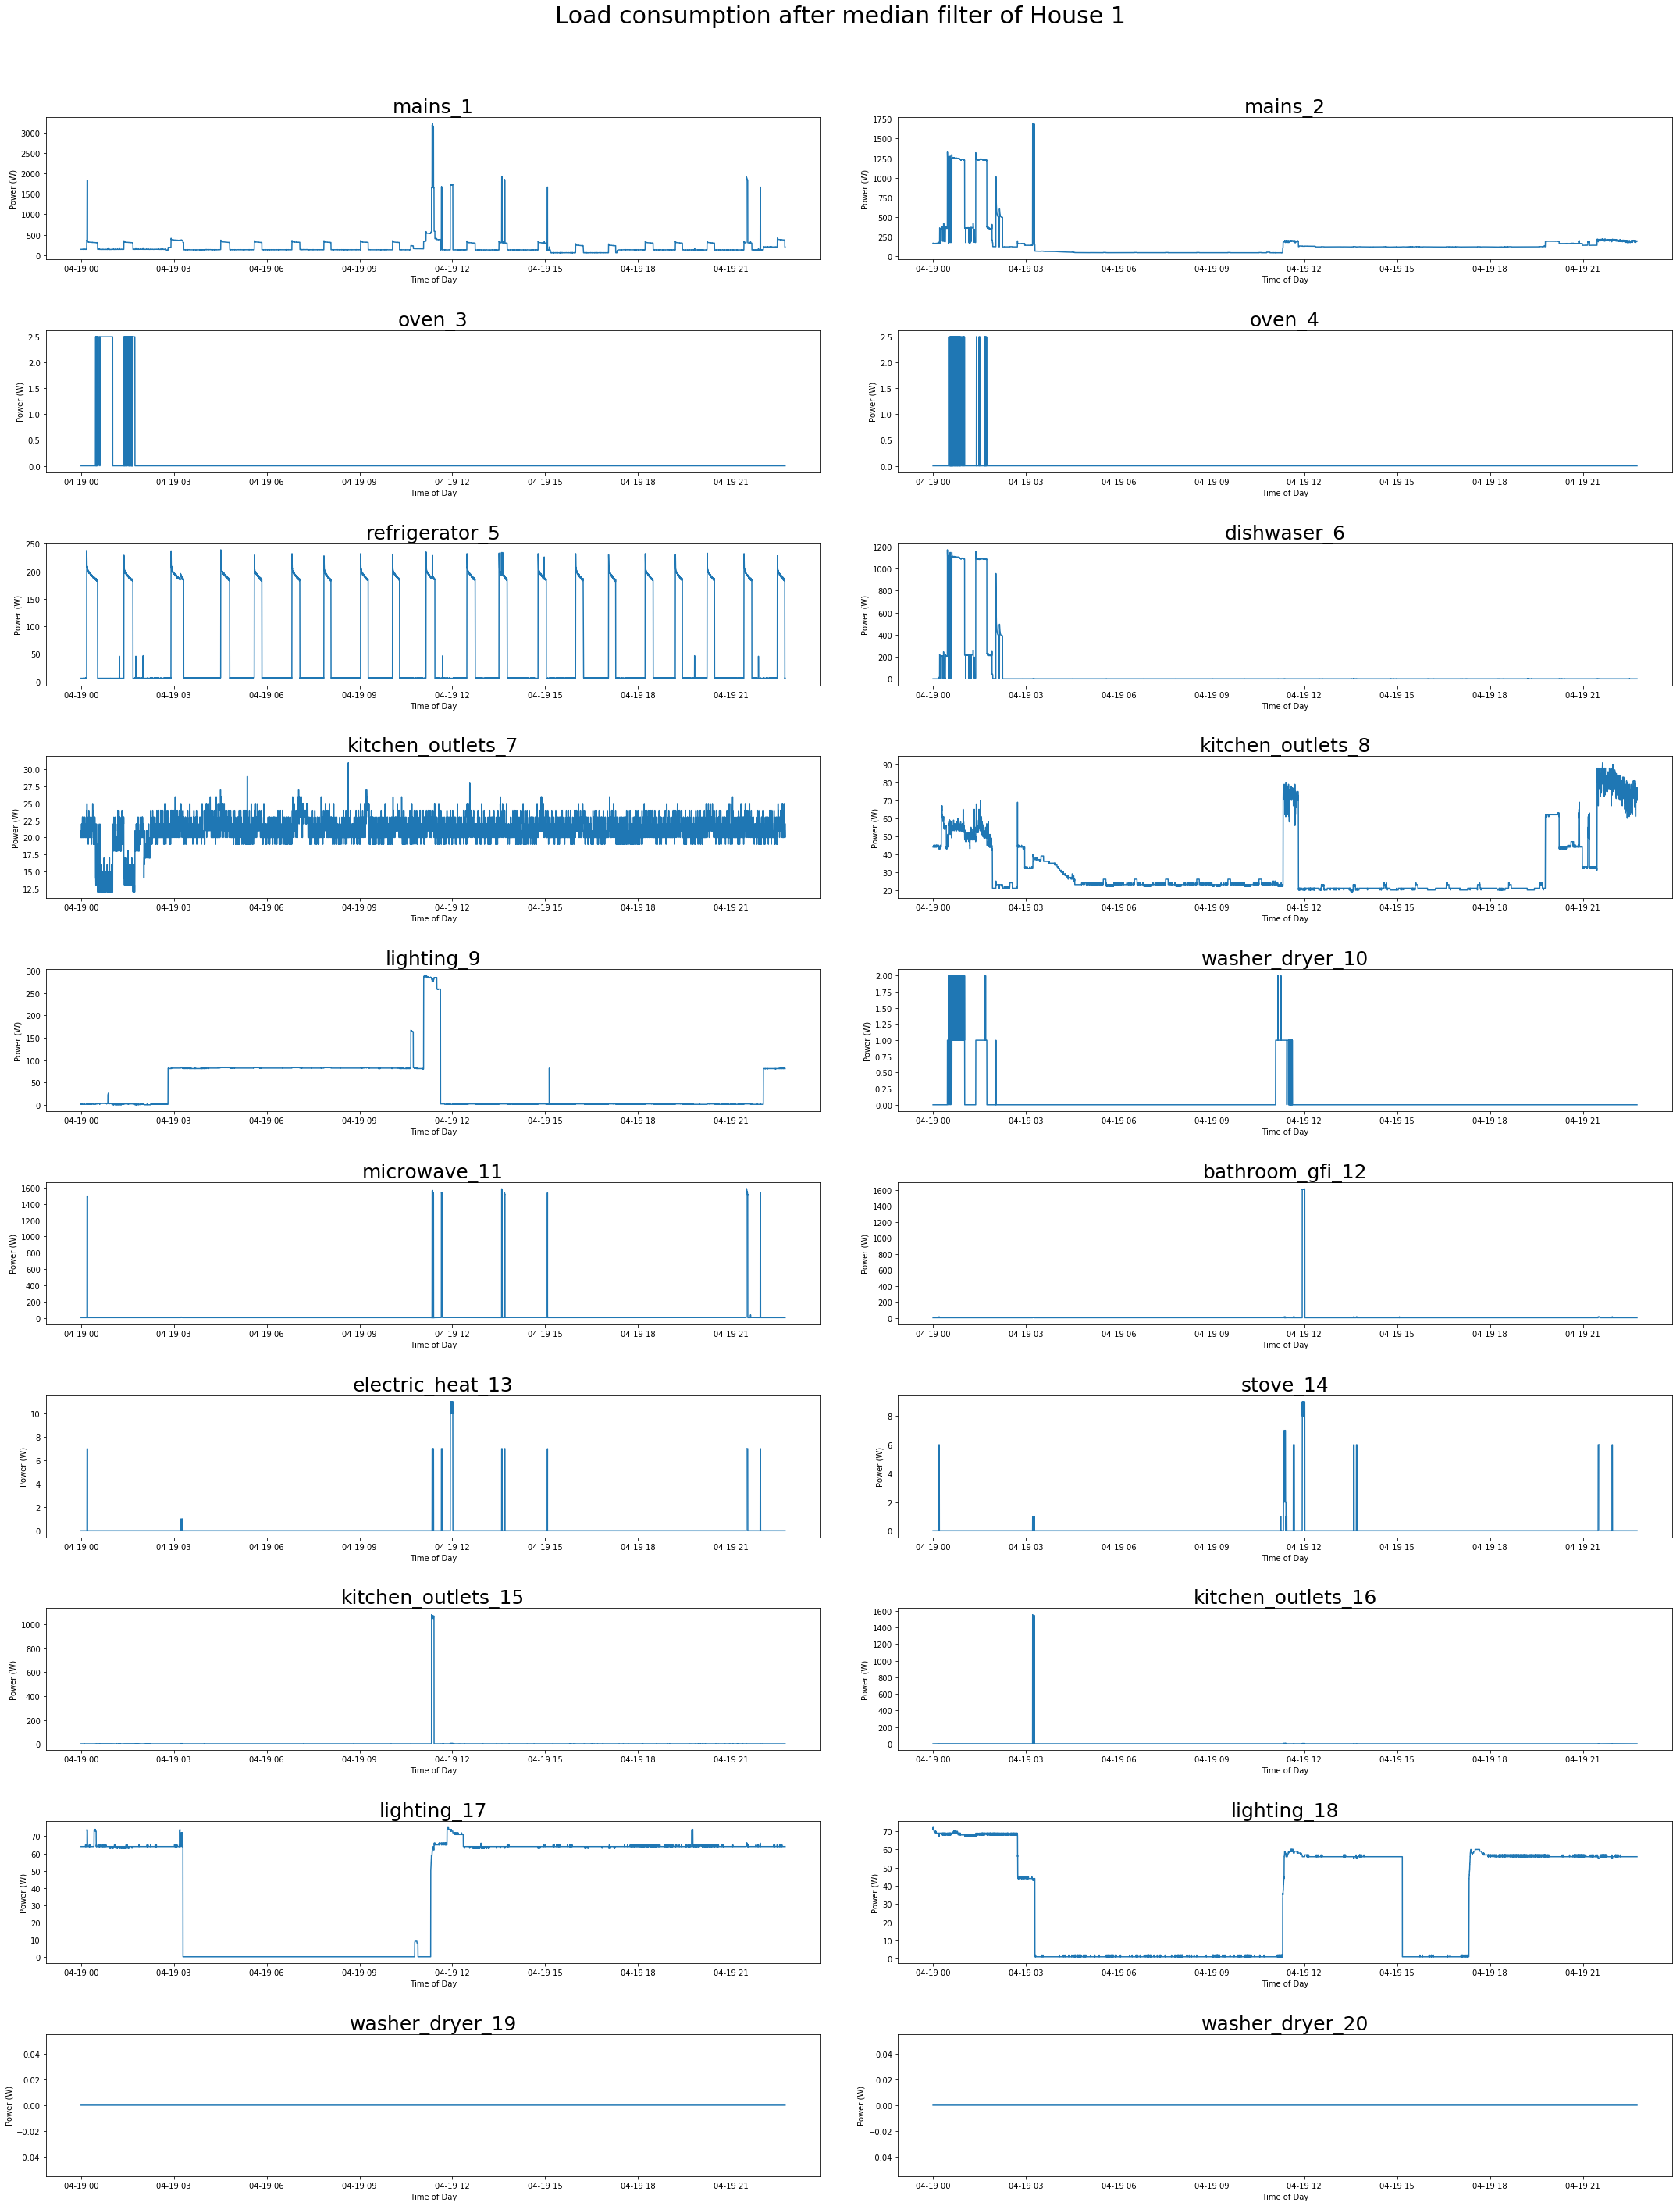

In [252]:
plot_data(median_filtered_df[1], 1, "Load consumption after median filter of House 1")

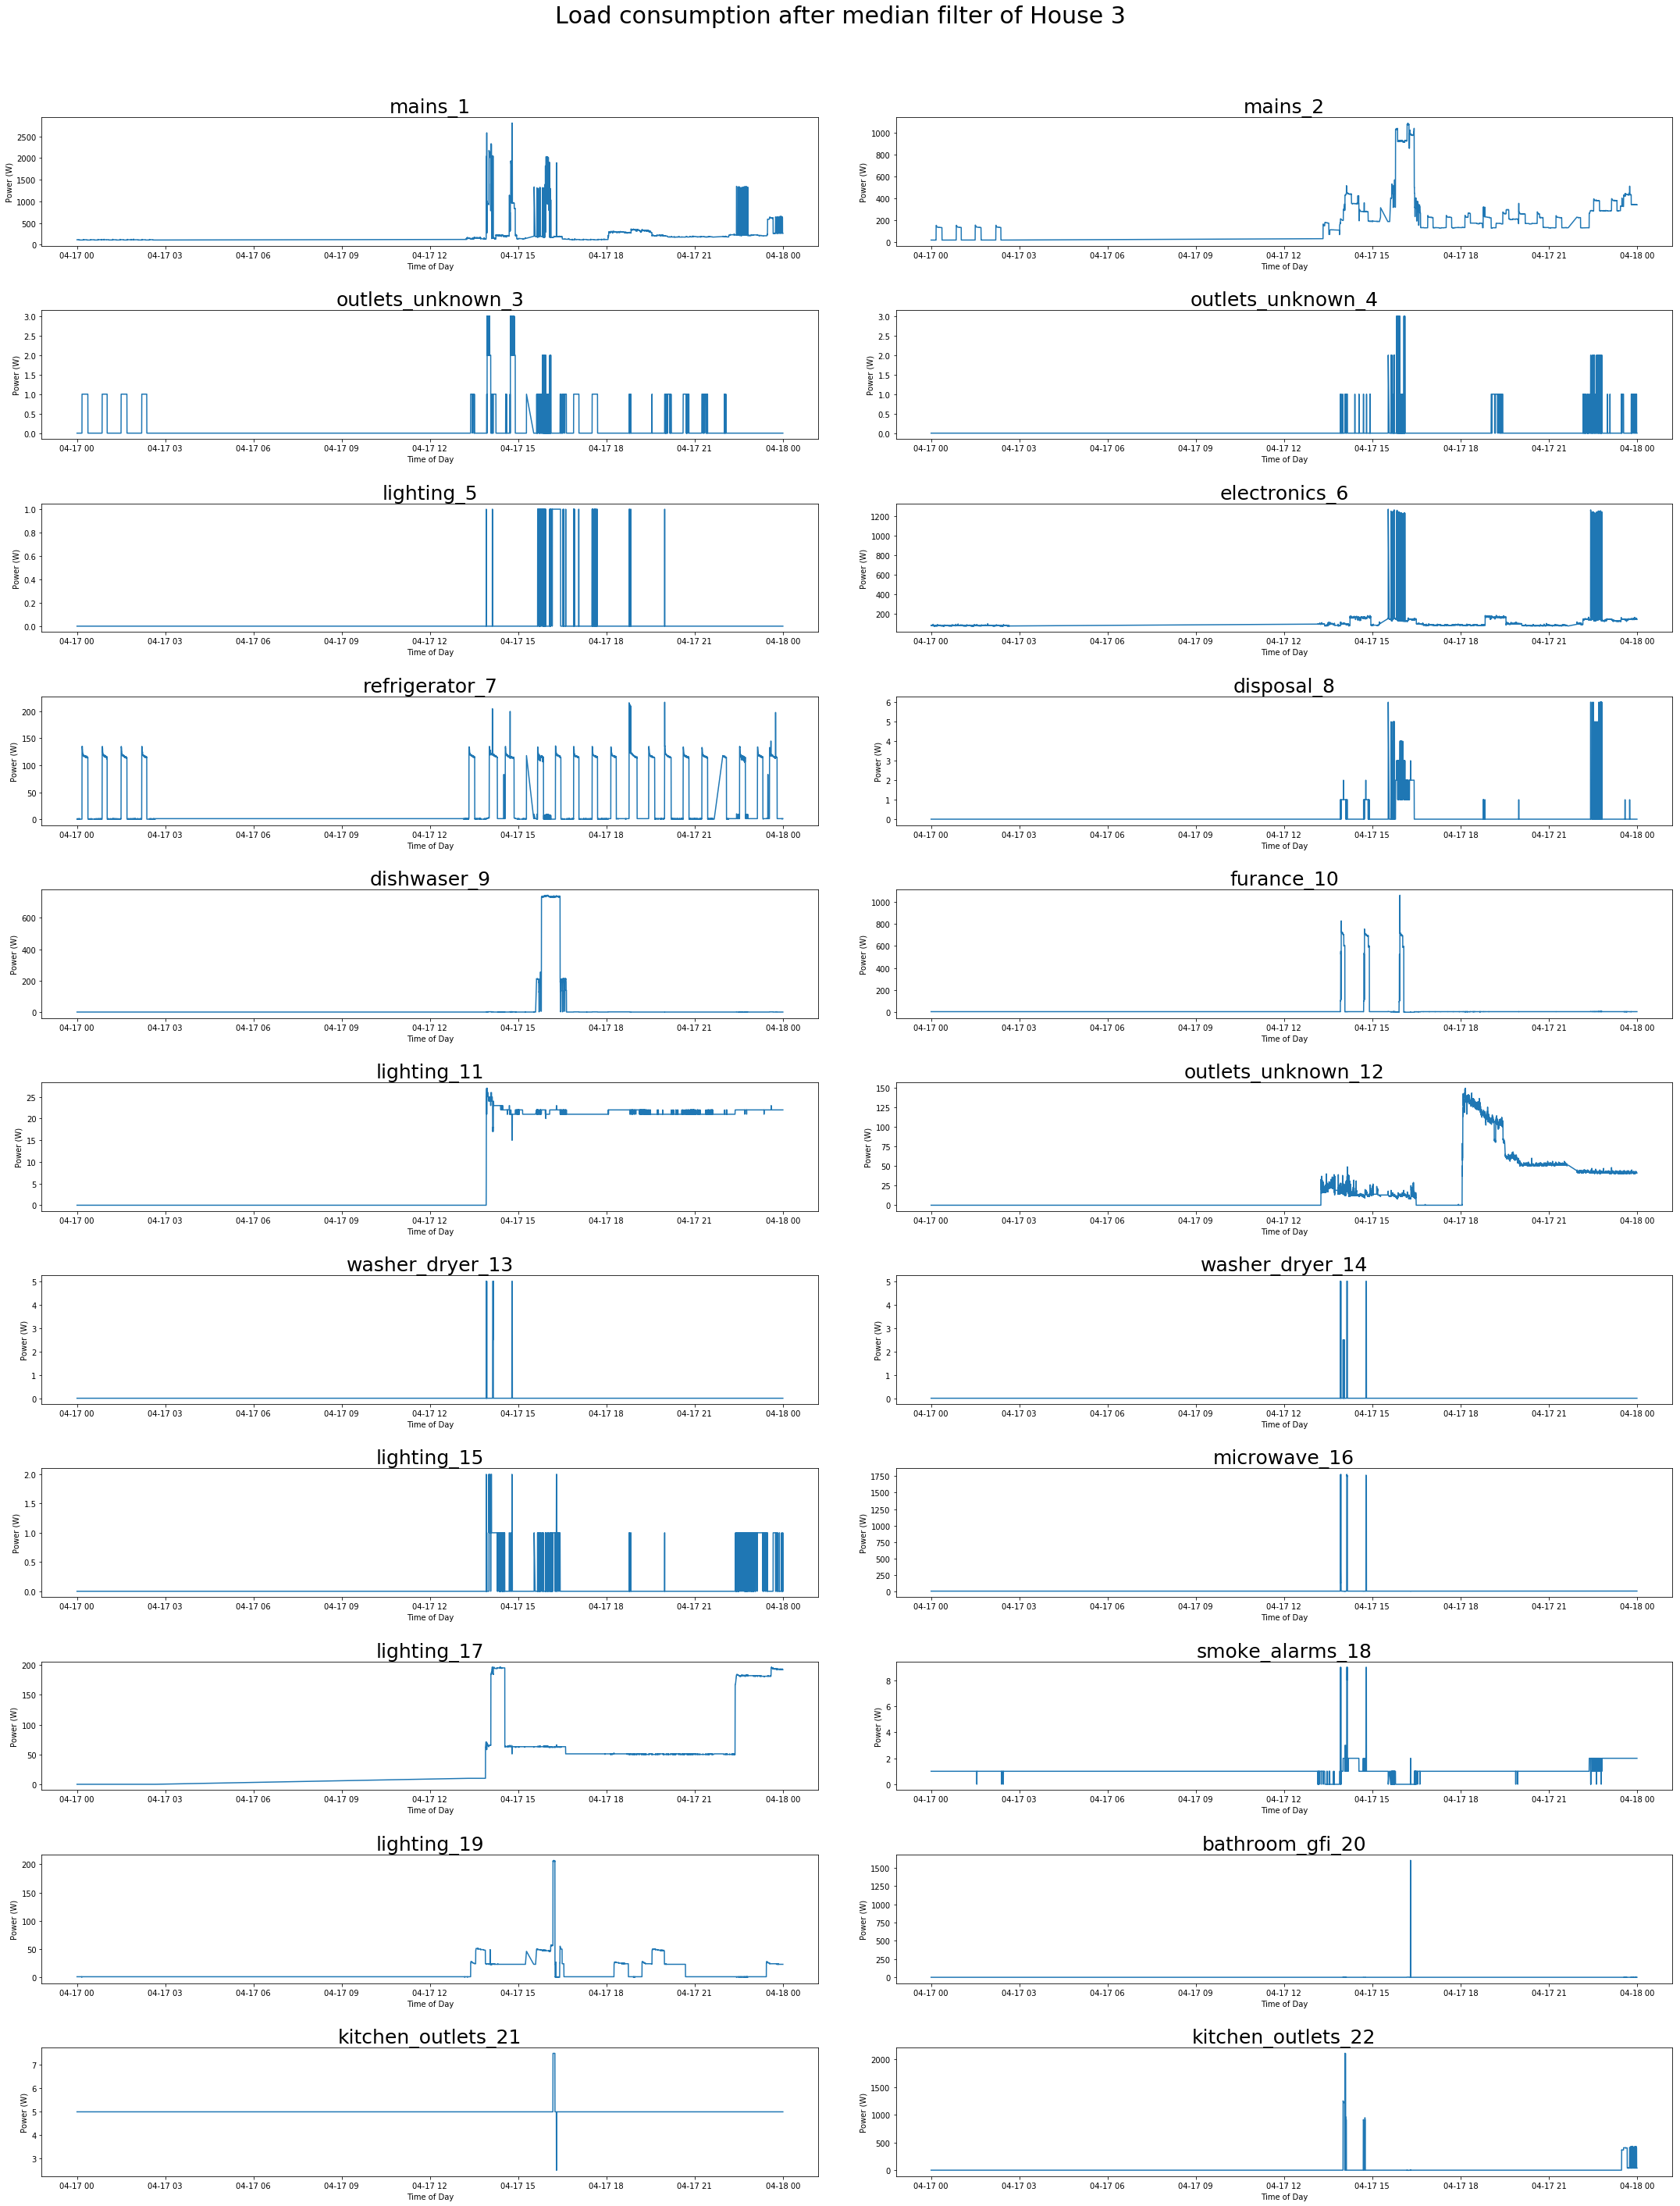

In [254]:
plot_data(median_filtered_df[3], 3, "Load consumption after median filter of House 3")

### Applying Chi square test and Goodness-of-Fit test to detect event in the power signals of the appliances

The Goodnes of Fit method aims to establish that a data could be derived given some probability distribution. Here, we rely on the fact that the distribution before and after and event occurs should be different. Assume that we have n independent and identically distributed samples drawn from an unknown distribution $G(x)$ (the training set/pre-event window). Given some distribution function $F(y)$ (the test set/detection window), we can formulate the hypotheses:

$$ H_0 : G(x) = F(y) $$
$$ H_1 : G(x) \neq F(y) $$

In the case where an event is detected in the appliance power signal, we would reject the null hypothesis. The chi-square goodnes of fit test for event detection is given by:

$$ l_{GOF} = \sum_{i=1}^{n} \frac{(y_i-x_i)^2}{x_i} $$

where $x_i,i=1,...,n$, is the sample from the pre-event window and $y_i,i=1,...,n$ is the sample from the detection window. If an event occurs, we expect the value $l_{GOF}$ to be high such that $l_{GOF} > X^2_{\alpha,df}$. The value of $\alpha$ we used here is 0.01 and 0.05 and the degree of freedom is the number of samples.

In [417]:
def chi_square(observed, estimate):
    numerator = (observed - estimate)**2
    #adding 1e-5 to prevent division by zero
    return np.sum(numerator/(estimate + 1e-5), axis=0)

We will apply this chi-square test on appliances with distinct signal patterns such as the refrigerators, lightings, and microwave. Our data is split into 100-samples of frame, we store the range of those frames whenever the chi-square values is over the threshold which indicates an event occurance.

In [565]:
#separate into 100-samples of frame.
inc = 100;
#chi-square value for alpha : degree of freedom, here degree of freedom is 100
threshold = {0.05 : 124.342, 0.01 : 135.807}
test_labels = ['refrigerator_5', 'microwave_11', 'lighting_17', 'lighting_18']
event_range = {}
for test in test_labels:
    event_range[test] = {}
    for i in range(0, len(median_filtered_df[1][dates[1][1]])-142, 200):
        pre_event_window = median_filtered_df[1].loc[dates[1][1], test][i:i+inc]
        detection_window = median_filtered_df[1].loc[dates[1][1], test][i+inc:i+inc+inc]
        csq = chi_square(detection_window.values, pre_event_window.values)
        if csq > threshold[0.05]:
            event_range[test][i] = i+inc+inc

In [566]:
event_range

{'lighting_17': {3000: 3200, 10000: 10200, 10200: 10400, 10600: 10800},
 'lighting_18': {2400: 2600,
  3000: 3200,
  10600: 10800,
  14200: 14400,
  16200: 16400},
 'microwave_11': {0: 200,
  3000: 3200,
  10600: 10800,
  11000: 11200,
  12800: 13000,
  14200: 14400,
  20200: 20400,
  20600: 20800},
 'refrigerator_5': {0: 200,
  400: 600,
  1000: 1200,
  1200: 1400,
  1400: 1600,
  1800: 2000,
  2600: 2800,
  3000: 3200,
  4200: 4400,
  4400: 4600,
  5200: 5400,
  5400: 5600,
  6400: 6600,
  6600: 6800,
  7200: 7400,
  7600: 7800,
  8400: 8600,
  8600: 8800,
  9400: 9600,
  9600: 9800,
  10400: 10600,
  10800: 11000,
  11600: 11800,
  12000: 12200,
  12600: 12800,
  13000: 13200,
  13800: 14000,
  14200: 14400,
  15000: 15200,
  15200: 15400,
  16000: 16200,
  16200: 16400,
  17200: 17400,
  17400: 17600,
  18000: 18200,
  18200: 18400,
  18600: 18800,
  19000: 19200,
  19200: 19400,
  20200: 20400,
  20400: 20600,
  20600: 20800,
  21200: 21400}}

Let's extract the point in which the event occur

In [568]:
event_index = {}
for key in event_range:
    event_index[key] = []
    for start, end in event_range[key].items():
        val = median_filtered_df[1].loc[dates[1][1], key][start:end]
        mask = ((median_filtered_df[1].index < val.diff().abs().idxmax()) & 
                (median_filtered_df[1].index > dates[1][1]))
        event_index[key].append(median_filtered_df[1].loc[mask, 'refrigerator_5'].index[-1])

In [569]:
event_index

{'lighting_17': [Timestamp('2011-04-19 03:17:32'),
  Timestamp('2011-04-19 10:46:48'),
  Timestamp('2011-04-19 10:53:08'),
  Timestamp('2011-04-19 11:17:56')],
 'lighting_18': [Timestamp('2011-04-19 02:44:17'),
  Timestamp('2011-04-19 03:17:28'),
  Timestamp('2011-04-19 15:10:00'),
  Timestamp('2011-04-19 11:17:56'),
  Timestamp('2011-04-19 17:19:09')],
 'microwave_11': [Timestamp('2011-04-19 00:12:17'),
  Timestamp('2011-04-19 13:36:27'),
  Timestamp('2011-04-19 15:04:19'),
  Timestamp('2011-04-19 21:29:40'),
  Timestamp('2011-04-19 11:21:37'),
  Timestamp('2011-04-19 03:13:03'),
  Timestamp('2011-04-19 21:57:25'),
  Timestamp('2011-04-19 11:40:34')],
 'refrigerator_5': [Timestamp('2011-04-19 00:10:55'),
  Timestamp('2011-04-19 06:48:47'),
  Timestamp('2011-04-19 21:40:33'),
  Timestamp('2011-04-19 10:17:31'),
  Timestamp('2011-04-19 17:16:34'),
  Timestamp('2011-04-19 07:04:08'),
  Timestamp('2011-04-19 19:12:08'),
  Timestamp('2011-04-19 11:08:47'),
  Timestamp('2011-04-19 13:46:08'

Plotting the data with event detection

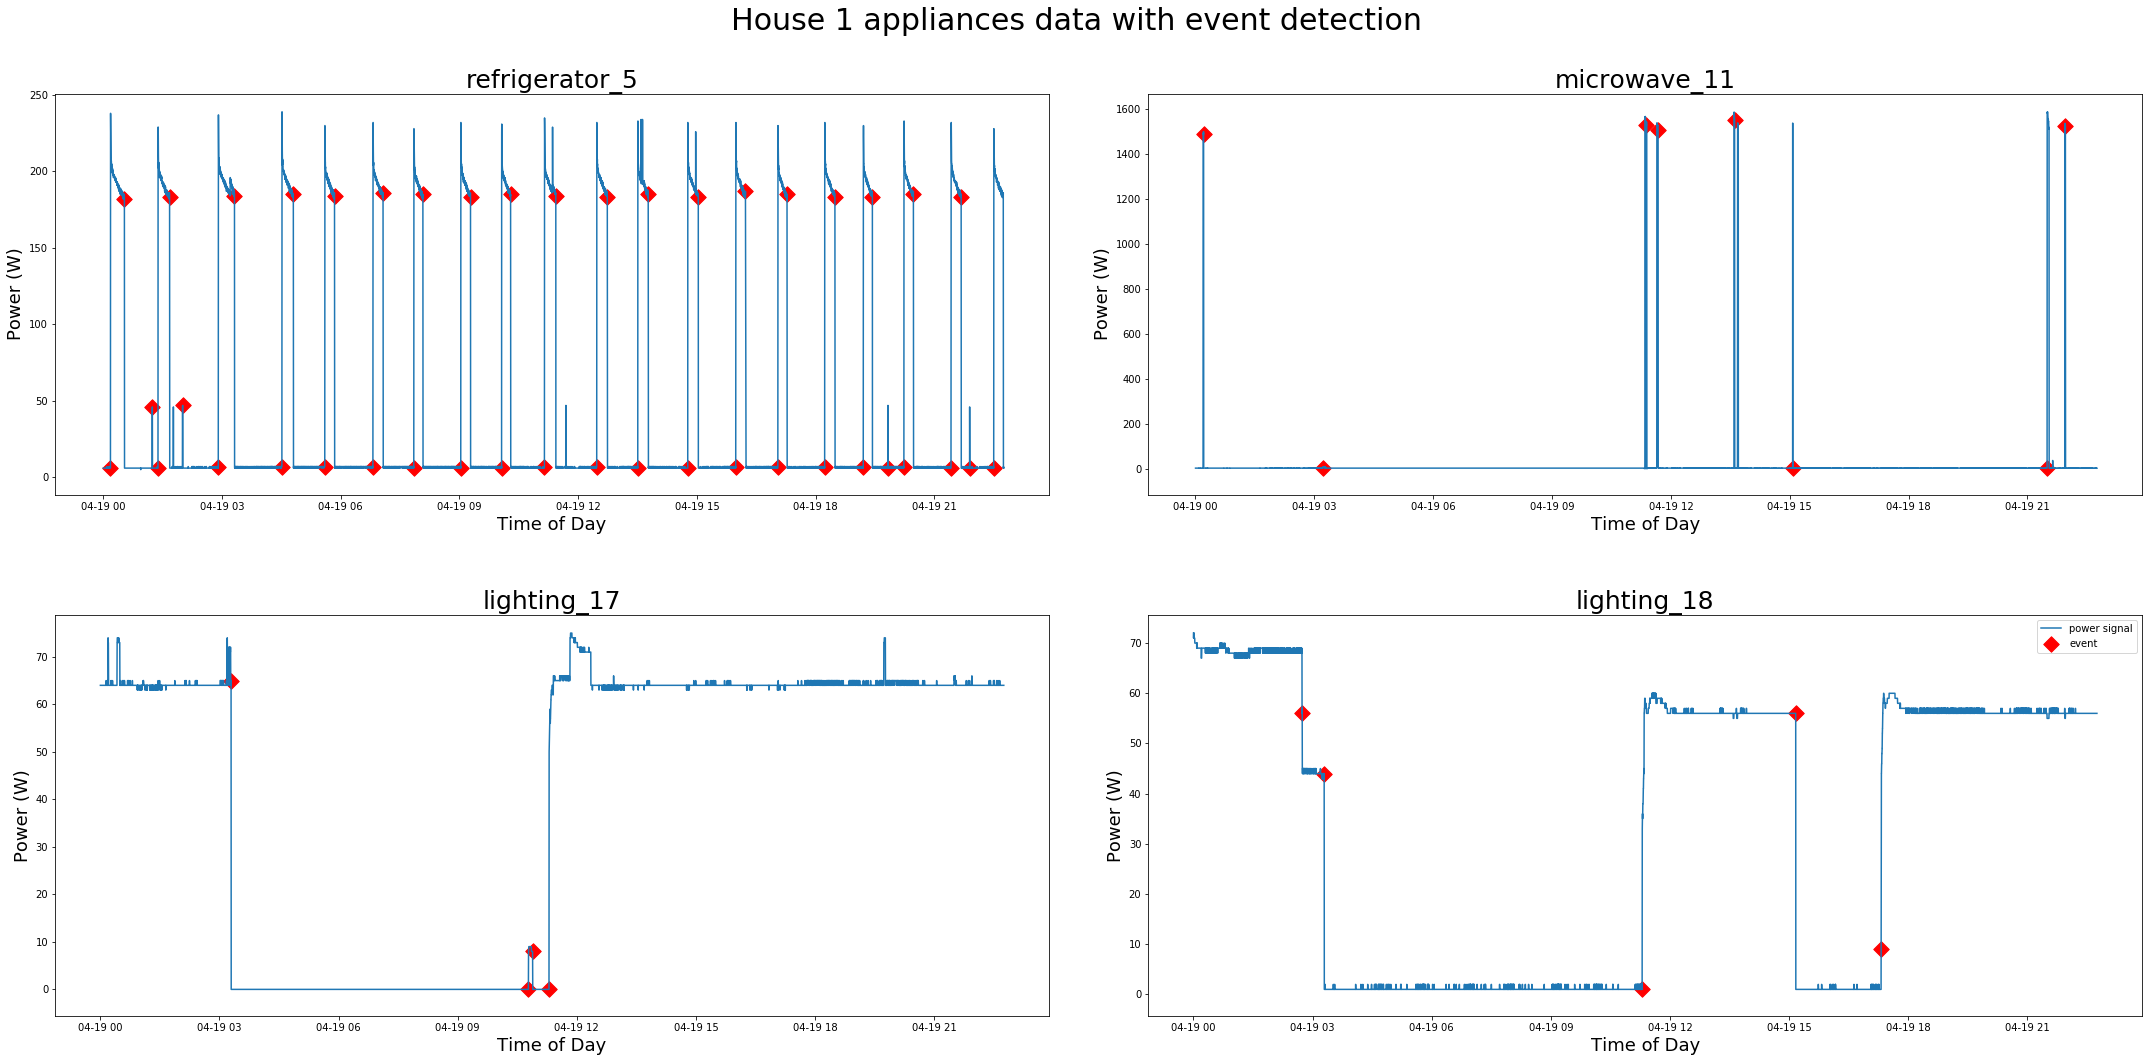

In [579]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))

for i in range(len(test_labels)):
    axes.flat[i].plot(median_filtered_df[1].loc[dates[1][1], test_labels[i]])
    axes.flat[i].scatter(event_index[test_labels[i]],
                         median_filtered_df[1].loc[event_index[test_labels[i]], \
                                                   test_labels[i]].values,
                         s=120, marker="D", color='r')
    axes.flat[i].set_title(test_labels[i], fontsize='25')
    axes.flat[i].set_xlabel("Time of Day", fontsize=18)
    axes.flat[i].set_ylabel("Power (W)", fontsize=18)
    plt.legend(['power signal', 'event'])
    
plt.suptitle("House 1 appliances data with event detection", fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.9, hspace=0.3, wspace=0.1)

Next we should label the detected events into ON/OFF states to be used as an input for classification using naive bayes classifier in the following sections.

We will set power threshold of 50 watt, and consider all power signal below 50 watt to be OFF states, we label OFF states as 0 and ON states as 1

In [599]:
power_threshold = 50

appliances_states = {}
for key in event_index:
    appliances_states[key] = np.where(median_filtered_df[1].loc[dates[1][1], key] > 50, 1, 0)

In [600]:
appliances_states

{'lighting_17': array([1, 1, 1, ..., 1, 1, 1]),
 'lighting_18': array([1, 1, 1, ..., 1, 1, 1]),
 'microwave_11': array([0, 0, 0, ..., 0, 0, 0]),
 'refrigerator_5': array([0, 0, 0, ..., 0, 0, 0])}

In [618]:
df_states = {}
for key in appliances_states:
    ab = median_filtered_df[1].loc[dates[1][1], key]
    bc = appliances_states[key]
    df_states[key] = pd.DataFrame(np.column_stack((ab.values,bc)),
                                  index=ab.index, columns=['power', 'states'])
    
    display(key)
    display(df_states[key].head())

'refrigerator_5'

,power,states
2011-04-19 00:00:03,6.0,0.0
2011-04-19 00:00:06,6.0,0.0
2011-04-19 00:00:10,6.0,0.0
2011-04-19 00:00:18,6.0,0.0
2011-04-19 00:00:22,6.0,0.0


'lighting_17'

,power,states
2011-04-19 00:00:03,64.0,1.0
2011-04-19 00:00:06,64.0,1.0
2011-04-19 00:00:10,64.0,1.0
2011-04-19 00:00:18,64.0,1.0
2011-04-19 00:00:22,64.0,1.0


'microwave_11'

,power,states
2011-04-19 00:00:03,4.0,0.0
2011-04-19 00:00:06,4.0,0.0
2011-04-19 00:00:10,4.0,0.0
2011-04-19 00:00:18,4.0,0.0
2011-04-19 00:00:22,4.0,0.0


'lighting_18'

,power,states
2011-04-19 00:00:03,72.0,1.0
2011-04-19 00:00:06,71.0,1.0
2011-04-19 00:00:10,71.0,1.0
2011-04-19 00:00:18,72.0,1.0
2011-04-19 00:00:22,72.0,1.0


### Cross Validation and Naive Bayes Classifier

We will split the train and test size into 70-30 percent of the states labeled data from above.

In [666]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB

In [667]:
#Simple Train-Test split
gnb = {}
x_train = {}
x_test = {}
y_pred = {}

features = ['power']
for key in df_states:
    x_train[key], x_test[key] = train_test_split(df_states[key], 
                                                 test_size=0.3, random_state=None)
    
    #Instantiate the classifier
    gnb[key] = GaussianNB()
    
    #Train classifier
    gnb[key].fit(x_train[key][features].values, x_train[key]['states'])
    y_pred[key] = gnb[key].predict(x_test[key][features])

Performance metrics using confusion matrix

In [668]:
from sklearn.metrics import confusion_matrix

In [669]:
c_matrix = {}
for key in df_states:
    y_true = x_test[key]['states'].values
    c_matrix[key] = confusion_matrix(y_true, y_pred[key])
    display(key)
    display(c_matrix[key])

'refrigerator_5'

array([[4954,    8],
       [   0, 1501]])

'lighting_17'

array([[2310,    1],
       [   0, 4152]])

'microwave_11'

array([[6406,    3],
       [   0,   54]])

'lighting_18'

array([[2893,  175],
       [   0, 3395]])

From the confusion matrix, various metrics can be calculated, such as:

Accuracy:

$$ \frac{TP+TN}{TP+TN+FP+FN} $$

Recall:

$$ \frac{TP}{TP+FN} $$

Specificity:

$$ \frac{TN}{TN+FP} $$

Precision:

$$ \frac{TP}{TP+FP} $$

where:

TP = True Postive (Actual ON, Predicted ON)

TN = True Negative (Actual OFF, Predicted OFF)

FP = False Postive (Actual OFF, Predicted ON)

FN = False Negative (Actual ON, Predicted OFF)



In [689]:
accuracy = {}
recall = {}
specificity = {}
precision = {}

for key in c_matrix:
    TP = c_matrix[key][1,1]
    FP = c_matrix[key][0,1]
    TN = c_matrix[key][0,0]
    FN = c_matrix[key][1,0]
    
    accuracy[key] = (TP+TN) / (TP+FP+TN+FN)
    recall[key] = TP / (TP+FN)
    specificity[key] = TN / (FP+TN)
    precision[key] = TP / (TP+FP)
    
    print("metrics for {}".format(key))
    print("Accuracy: {}".format(accuracy[key]))
    print("Recall: {}".format(recall[key]))
    print("Specificity: {}".format(specificity[key]))
    print("Precision: {}\n".format(precision[key]))

metrics for refrigerator_5
Accuracy: 0.998762184743927
Recall: 1.0
Specificity: 0.9983877468762595
Precision: 0.9946984758117959

metrics for lighting_17
Accuracy: 0.9998452730929909
Recall: 1.0
Specificity: 0.9995672868887927
Precision: 0.9997592102094871

metrics for microwave_11
Accuracy: 0.9995358192789726
Recall: 1.0
Specificity: 0.9995319082540178
Precision: 0.9473684210526315

metrics for lighting_18
Accuracy: 0.9729227912734024
Recall: 1.0
Specificity: 0.9429595827900913
Precision: 0.9509803921568627



### Cross Validation using k-folds where k=10 (WIP)

In [663]:
#10-folds Cross Validation
kf = KFold(n_splits=10)
X_train = {}
X_test = {}
GNB = {}
for key in df_states:
    for train, test in kf.split(df_states[key]):
        X_train[key] = df_states[key][train]
        X_test[key] = df_states[key][test]
        
        #Instantiate classifier
        GNB[key] = GaussianNB()
        
        #Train classifier
        GNB[key].fit(X_train[key][features].values, X_train[key]['states'])
        

10